| Name         | Innomail                       | Group     |
| ------------ | ------------------------------ | --------- |
| Egor Machnev | e.machnev@innopolis.university | B22-AI-02 |


# Context-sensitive Spelling Correction

The goal of the assignment is to implement context sensitive spelling correction. The input to the code will be a set of lines of text, and the output will be the same lines with the spelling mistakes corrected.

## Context-free Spelling Corrector

Let's start with the suggested [Norvig's Solution](https://norvig.com/spell-correct.html).

### Data download and preprocessing

In [1]:
! mkdir -p data
! [ ! -f data/big.txt ] && wget https://norvig.com/big.txt -O data/big.txt

In [2]:
def read_text(path: str) -> str:
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


norvig_text = read_text("data/big.txt")

Tokenize the text and see the statistics of word occurrences.

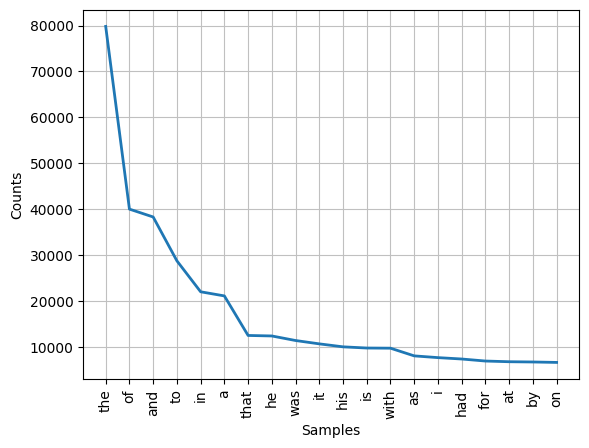

(32198, 1115585)

In [3]:
import re

from nltk import FreqDist


def norvig_tokenize(text: str) -> list:
    return re.findall(r"\w+", text.lower())


norvig_fdist = FreqDist(norvig_tokenize(norvig_text))
norvig_fdist.plot(20, show=True)
norvig_fdist.B(), norvig_fdist.N()

### Norvig's Solution

Let's reproduce the code of [Norvig's Solution](https://norvig.com/spell-correct.html).

In [4]:
from string import ascii_lowercase


class NorvigCorrector:
    def __init__(self, fdist: FreqDist) -> None:
        self.fdist = fdist

    def __call__(self, sent: str) -> str:
        return " ".join(self.correction(word) for word in norvig_tokenize(sent))

    def P(self, word: str) -> float:
        """Compute the probability of word."""
        return self.fdist.freq(word)

    def correction(self, word: str) -> str:
        """Find the most likely spelling correction for word."""
        return max(self.candidates(word), key=self.P)

    def candidates(self, word: str) -> set[str]:
        """Generate possible spelling corrections for word."""
        return (
            self.known([word])
            or self.known(self.edits1(word))
            or self.known(self.edits2(word))
            or {word}
        )

    def known(self, words: list[str]) -> set[str]:
        """The subset of words that appear in the word distribution."""
        return {w for w in words if w in self.fdist}

    def edits1(self, word: str) -> set[str]:
        """All edits that are one edit away from word."""
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in ascii_lowercase]
        inserts = [L + c + R for L, R in splits for c in ascii_lowercase]
        return set(deletes + transposes + replaces + inserts)

    def edits2(self, word: str) -> set[str]:
        """All edits that are two edits away from word."""
        return {e2 for e1 in self.edits1(word) for e2 in self.edits1(e1)}

### Evaluation

The [vishnun/SpellGram](https://huggingface.co/datasets/vishnun/SpellGram) dataset was selected for quality assessment.

In [5]:
from datasets import load_dataset

eval_set = load_dataset("vishnun/SpellGram", split="train[:10%]")
len(eval_set)

4000

[WER](https://huggingface.co/spaces/evaluate-metric/wer/blob/main/README.md), [CER](https://huggingface.co/spaces/evaluate-metric/cer/blob/main/README.md) and [F1](https://huggingface.co/spaces/evaluate-metric/f1/blob/main/README.md) are involved as quality metrics.

In [6]:
from typing import Callable

from nltk.metrics import edit_distance
from tqdm import tqdm


def calculate_wer(y_true: str, y_pred: str) -> float:
    """Compute the Word Error Rate (WER) between `y_true` and `y_pred`."""
    y_true, y_pred = y_true.split(), y_pred.split()
    return edit_distance(y_true, y_pred) / len(y_true) if y_true else 0.0


def calculate_cer(y_true: str, y_pred: str) -> float:
    """Compute the Character Error Rate (CER) between `y_true` and `y_pred`."""
    return edit_distance(y_true, y_pred) / len(y_true) if y_true else 0.0


def calculate_f1(y_true: str, y_pred: str) -> float:
    """Compute the F1 score between `y_true` and `y_pred`."""
    y_true, y_pred = set(y_true.split()), set(y_pred.split())

    tp = len(y_true & y_pred)  # True Positives
    fp = len(y_pred - y_true)  # False Positives
    fn = len(y_true - y_pred)  # False Negatives

    if tp == 0:
        return 0.0

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return 2 * (precision * recall) / (precision + recall)


def evaluate_corrector(corr_fn: Callable[[str], str]) -> None:
    """Evaluate the spell corrector. Print WER, CER, and F1 metrics."""
    total_wer, total_cer, total_f1 = 0.0, 0.0, 0.0

    for source, target in tqdm(
        zip(eval_set["source"], eval_set["target"]), total=len(eval_set)
    ):
        correction = corr_fn(source)

        total_wer += calculate_wer(target, correction)
        total_cer += calculate_cer(target, correction)
        total_f1 += calculate_f1(target, correction)

    avg_wer = total_wer / len(eval_set)
    avg_cer = total_cer / len(eval_set)
    avg_f1 = total_f1 / len(eval_set)

    print(f"{avg_wer=:.4}, {avg_cer=:.4}, {avg_f1=:.4}")

Drumroll... 🥁

In [7]:
evaluate_corrector(NorvigCorrector(norvig_fdist))

100%|██████████| 4000/4000 [02:57<00:00, 22.50it/s]

avg_wer=0.1522, avg_cer=0.03912, avg_f1=0.8513


### Corpus pumping

Note that the [big.txt](https://norvig.com/big.txt) file proposed in [Norvig's Solution](https://norvig.com/spell-correct.html) contains only 32198 unique words. What about increasing the vocabulary?

In [8]:
import nltk

nltk.download("brown")
nltk.download("reuters")
nltk.download("webtext")

nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

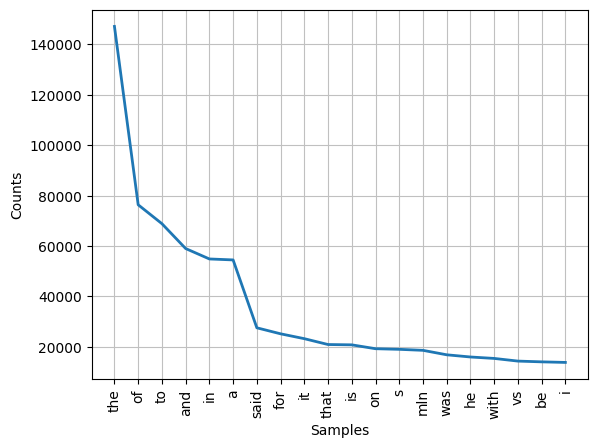

(63596, 2777898)

In [9]:
from itertools import chain

from nltk.corpus import brown, reuters, webtext

bigger_text = list(
    filter(
        str.isalnum,  # Filter out non-alphanumeric words
        map(str.lower, chain(brown.words(), reuters.words(), webtext.words())),
    )
)

bigger_fdist = FreqDist(bigger_text)
bigger_fdist.plot(20, show=True)
bigger_fdist.B(), bigger_fdist.N()

Drumroll... 🥁

In [10]:
evaluate_corrector(NorvigCorrector(bigger_fdist))

100%|██████████| 4000/4000 [02:19<00:00, 28.67it/s]

avg_wer=0.1477, avg_cer=0.03603, avg_f1=0.8575


## Context-sensitive Spelling Corrector

Well, increasing the vocabulary gave a marginal improvement in the metrics. Let's try playing with context.

### N-grams

Start with what matters most — context. The concept of n-grams, details about which can be found on [Wikipedia](https://en.wikipedia.org/wiki/N-gram), proves to be extremely useful for conducting statistical analysis.

(Also see https://books.google.com/ngrams/)

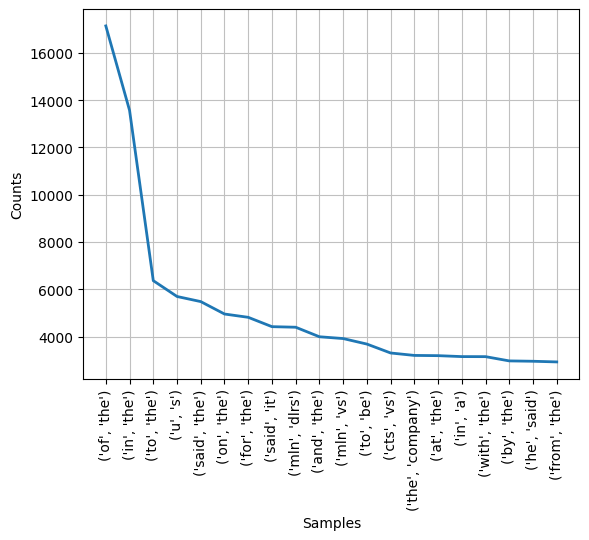

(881316, 2777897)

In [11]:
from nltk.util import ngrams

bigram_fdist = FreqDist(ngrams(bigger_text, 2))
bigram_fdist.plot(20, show=True)
bigram_fdist.B(), bigram_fdist.N()

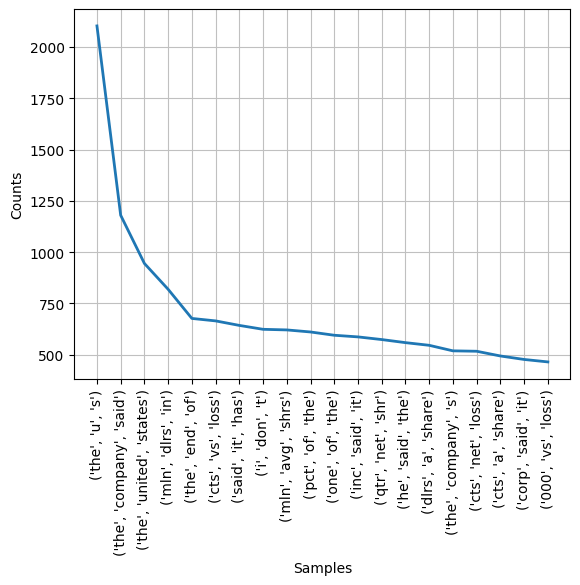

(1913285, 2777896)

In [12]:
trigram_fdist = FreqDist(ngrams(bigger_text, 3))
trigram_fdist.plot(20, show=True)
trigram_fdist.B(), trigram_fdist.N()

### Implementation

Let's implement a context-sensitive spell checker. The idea is to use n-grams to correct spelling errors. This means that we will evaluate the probability of the occurrence of a word taking into account its context (e.g. bigrams and trigrams). This way, for each candidate correction, we can not only check its individual probability, but also assess how well it fits into the sentence context.

We will also implement beam search to find the most likely correction. Beam search allows us to efficiently traverse possible correction variants by limiting the number of hypotheses considered to the most promising ones. For each word in the sentence, we generate a list of candidates, compute their logarithmic scores considering the context, and then select the best hypotheses for further evaluation.

This approach allows us not only to correct spelling errors, but also to take context into account, which is especially important for accurate interpretation of ambiguous cases.

In [13]:
def tokenize(text: str) -> list[str]:
    """Tokenize text into words. Remove non-alphanumeric words and lowercase."""
    return [word.lower() for word in nltk.word_tokenize(text) if word.isalnum()]

In [14]:
import math


def safe_log(x: float, eps: float = 1e-10) -> float:
    """Compute the natural logarithm of x with a small epsilon."""
    return math.log(x + eps)

In [15]:
from functools import lru_cache
from heapq import nlargest


class ContextualCorrector:
    def __init__(
        self,
        fdist: FreqDist,
        bigram_fdist: FreqDist,
        trigram_fdist: FreqDist,
        *,
        beam_width: int = 10,
    ) -> None:
        self.norvig = NorvigCorrector(fdist)
        self.bigram_fdist = bigram_fdist
        self.trigram_fdist = trigram_fdist
        self.beam_width = beam_width

    def __call__(self, sent: str) -> str:
        words = tokenize(sent)
        beams = [(0.0, [])]

        for i, word in enumerate(words):
            beams = nlargest(
                self.beam_width,
                [
                    (
                        score + self.score_candidate(candidate, i, seq),
                        seq + [candidate],
                    )
                    for candidate in self.candidates(word)
                    for score, seq in beams
                ],
                key=lambda x: x[0],
            )

        return " ".join(beams and max(beams, key=lambda x: x[0])[1])

    def score_candidate(self, candidate: str, i: int, seq: list[str]) -> float:
        """Compute the score of candidate given the context."""
        score = safe_log(self.P(candidate))
        if i >= 1:
            score += safe_log(self.P_bigram(candidate, seq[-1]))
        if i >= 2:
            score += safe_log(self.P_trigram(candidate, seq[-2], seq[-1]))
        return score

    def P(self, word: str) -> float:
        """Compute the probability of word."""
        return self.norvig.P(word)  # P(word)

    def P_bigram(self, word: str, prev: str) -> float:
        """Compute the probability of word given prev."""
        n = self.norvig.fdist[prev]
        if n == 0:
            return 0.0
        return self.bigram_fdist[(prev, word)] / n  # P(word | prev)

    def P_trigram(self, word: str, prev1: str, prev2: str) -> float:
        """Compute the probability of word given prev1 and prev2."""
        n = self.bigram_fdist[(prev1, prev2)]
        if n == 0:
            return 0.0
        return self.trigram_fdist[(prev1, prev2, word)] / n  # P(word | prev1, prev2)

    @lru_cache(maxsize=None)
    def candidates(self, word: str) -> set[str]:
        """Generate possible spelling corrections for word."""
        return self.norvig.candidates(word)

### Evaluation

Drumroll... 🥁

In [16]:
evaluate_corrector(ContextualCorrector(bigger_fdist, bigram_fdist, trigram_fdist))

100%|██████████| 4000/4000 [02:11<00:00, 30.44it/s]

avg_wer=0.1376, avg_cer=0.03328, avg_f1=0.8674


## Justifications

During the development of the **Context-Sensitive Spelling Corrector**, core
mechanisms from the **Context-Free Spelling Corrector** were utilized, with the
addition of **N-grams** for contextual awareness and **Beam Search** for
selecting the best candidate.

### Datasets Used

For model training, I selected the Brown, Reuters, and WebText datasets from
NLTK. These corpora provide a diverse range of texts from various domains,
enhancing the accuracy of corrections.

### Relationship with Context-Free Spelling Corrector

The base error correction algorithm utilizes Edit1 and Edit2 from
[Norvig's Solution](https://norvig.com/spell-correct.html) without assigning
them specific weights. The candidate selection is made in the following order:

1. The model first checks if the word exists in the vocabulary.
2. If the word is missing, a **single edit operation** (Edit1) is attempted.
3. If Edit1 fails, **two edit operations** (Edit2) are attempted.
4. Supported corrections include **Delete, Transpose, Replace, and Insert**.

### N-gram Model

The model incorporates bigrams (2-grams) and trigrams (3-grams). To determine
the best correction,
[Bayesian probability](https://en.wikipedia.org/wiki/Bayesian_probability) is
used based on N-gram frequency.

### Best Correction Search Method

Beam Search is used with a beam width of 10. To efficiently select the best
candidates, N-Largest from HeapQ is utilized.

### Keyboard Layout Consideration

The concept of incorporating keyboard layout corrections was investigated;
however, subsequent testing revealed no substantial enhancement in correction
quality. Consequently, the final implementation is restricted to standard ASCII
lowercase character replacements.

### Metrics

Let's summarize the results in a table.

| Spelling Corrector Variant                          | sents | WER    | CER     | F1     |
| --------------------------------------------------- | ----- | ------ | ------- | ------ |
| Context-free Spelling Corrector                     | 02:57 | 0.1522 | 0.03912 | 0.8513 |
| Context-free Spelling Corrector (bigger vocabulary) | 02:19 | 0.1477 | 0.03603 | 0.8575 |
| Context-sensitive Spelling Corrector                | 02:11 | 0.1376 | 0.03328 | 0.8674 |

#### Key Observations

1. WER (Word Error Rate) Improvement
   - The **Context-Free Spelling Corrector** commences with a WER of **0.1522**.
   - The expansion of the vocabulary in the **Context-Free Spelling Corrector
     (bigger vocabulary)** reduces WER to **0.1477**, indicating that a more
     extensive vocabulary enables the recognition of more words correctly,
     leading to fewer unnecessary corrections.
   - The expansion of the vocabulary in the **Context-Free Spelling Corrector
     (bigger vocabulary)** reduces WER to **0.1477**, indicating that a more
     extensive vocabulary enables the recognition of more words correctly,
     leading to fewer unnecessary corrections.

2. CER (Character Error Rate) Improvement
   - The base Context-Free Spelling Corrector achieves a CER of 0.03912.
   - With a larger vocabulary, CER drops to 0.03603, meaning fewer
     character-level errors occur.
   - The Context-Sensitive Spelling Corrector achieves the optimal CER of
     0.03328, validating that incorporating context minimizes unnecessary
     character-level modifications.

3. F1-Score (Overall Accuracy and Balance)
   - The **Context-Free Spelling Corrector** achieves an F1-score of 0.8513.
   - The **bigger vocabulary** version improves it to 0.8575, showing better
     recall and precision in recognizing valid words.
   - The Context-Sensitive Spelling Corrector achieves the highest F1-score of
     0.8674, underscoring its superior accuracy in preserving meaning while
     making corrections.

#### Analysis of Speed Improvements

> Although caching mechanisms were incorporated into the Context-Sensitive
> Spelling Corrector, they yielded only a modest enhancement in processing
> speed. The significant increase in speed was primarily due to the expansion of
> vocabulary.

The initial dataset contained a relatively limited vocabulary. By expanding the
vocabulary, we were able to increase the number of known words, thereby reducing
the probability of encountering unknown words that required correction.
Consequently, the model spent less time attempting corrections, as it recognized
more words directly. This effect was observed across both the larger vocabulary
version of the Context-Free Spelling Corrector and the Context-Sensitive
Spelling Corrector.
